In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [67]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
   

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots(figsize=(14,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.grid(False)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Analysis

In [2]:
# Prepare data
demographic = pd.read_csv('../data/processed/demographic.csv')
severity = pd.read_csv('../data/processed/severity.csv', index_col=0)
features = demographic.columns 
X = demographic.astype(np.float64)
y = (severity >= 4).sum(axis=1)

In [4]:
needs_to_label = {0:'no needs', 1:'low_needs', 2:'moderate needs', 3:'high needs', 4:'very high needs'}
labels = ["no needs", "low needs", "moderate needs", "high needs", "very high needs"]
severity_to_needs = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4}
y = np.array([severity_to_needs[i] for i in y])
# Color vector, for illustration purposes
colors = {0:'b', 1:'r', 2:'g', 3:'c', 4:'y'}
y_c = np.array([colors[i] for i in y])

## Understanding the features

In [5]:
from yellowbrick.features import Rank2D
from yellowbrick.features.manifold import Manifold
from yellowbrick.features.pca import PCADecomposition

In [6]:
from yellowbrick.style import set_palette
set_palette('flatui')

### Feature covariance plot

/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


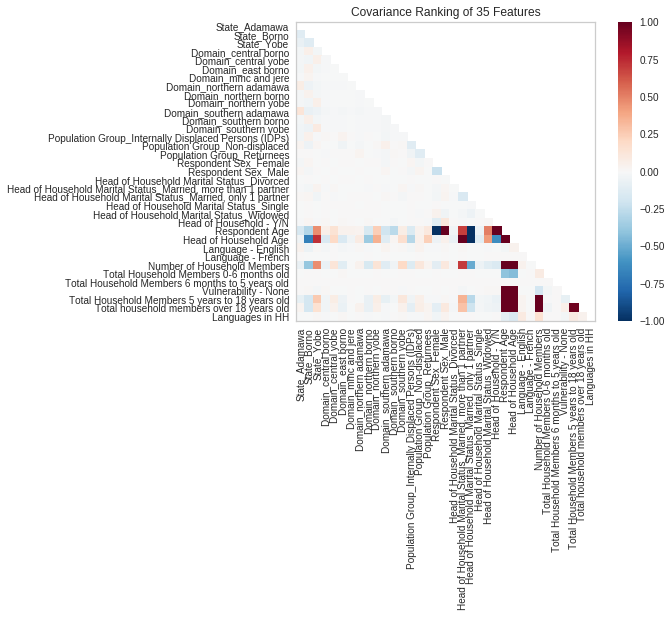

In [7]:
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

### Principal Component Projection

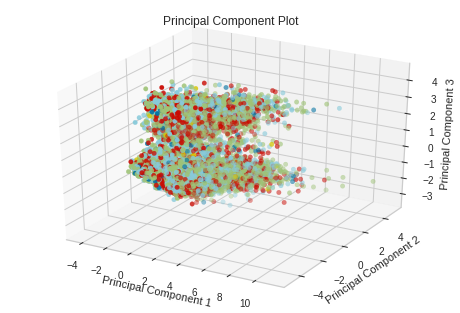

In [8]:
visualizer = PCADecomposition(scale=True, color = y_c, proj_dim=3)
visualizer.fit_transform(X, y)
visualizer.poof()

### Manifold projections

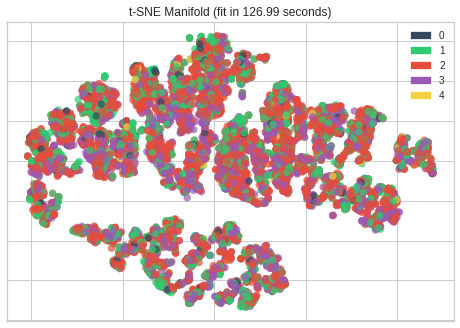

In [9]:
visualizer = Manifold(manifold='tsne', target='discrete')
visualizer.fit_transform(X, y)
visualizer.poof()

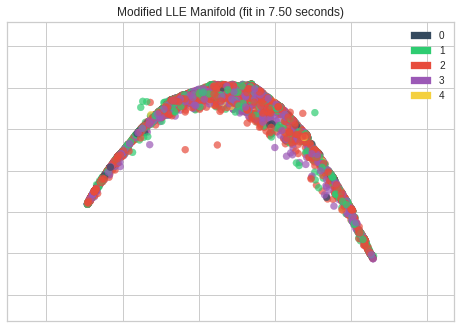

In [10]:
visualizer = Manifold(manifold='modified', target='discrete')
visualizer.fit_transform(X, y)
visualizer.poof()

No apparent structure from the PCA and Manifold projections.

### Class Balance

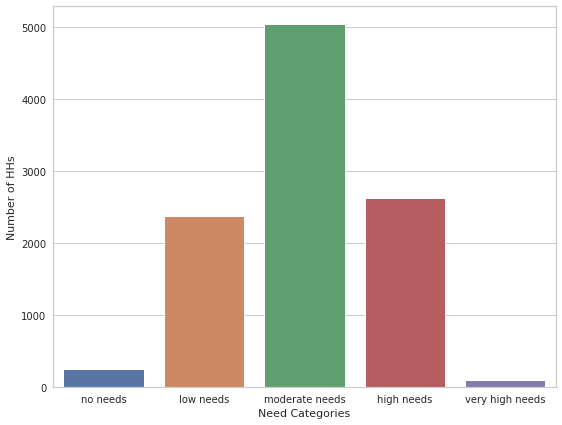

In [11]:
categories, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots(figsize=(9, 7))
sb.set(style="whitegrid")
sb.barplot(labels, counts, ax=ax, tick_label=labels)
ax.set(xlabel='Need Categories',
       ylabel='Number of HHs');

Heavy class imbalances. Use appropriate scoring metrics/measures.

### Learning and Validation

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from yellowbrick.model_selection import LearningCurve

In [32]:
cv = StratifiedKFold(10)
sizes = np.linspace(0.1, 1., 20)

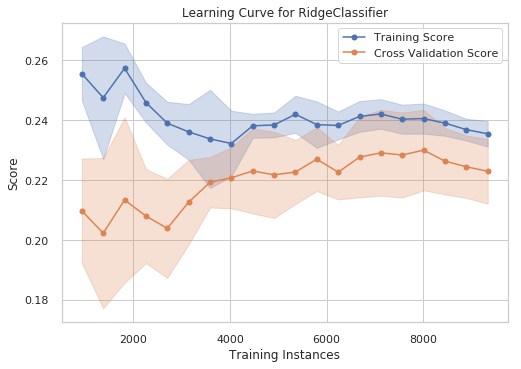

In [33]:
visualizer = LearningCurve(RidgeClassifier(), cv=cv, train_sizes=sizes, 
                           scoring='balanced_accuracy', n_jobs=-1)
visualizer.fit(X,y)
visualizer.poof()

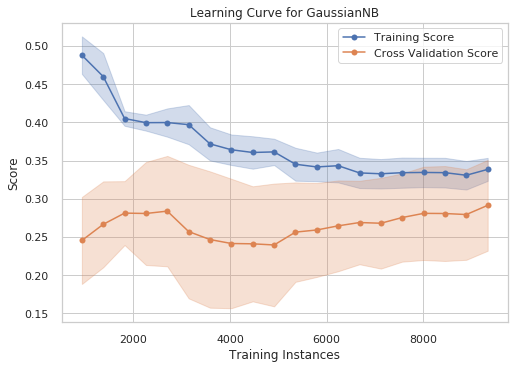

In [35]:
visualizer = LearningCurve(GaussianNB(), cv=cv, train_sizes=sizes, 
                           scoring='balanced_accuracy', n_jobs=-1)
visualizer.fit(X,y)
visualizer.poof()

### Classification

In [45]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
cv_ = StratifiedKFold(5)
class_weights = compute_class_weight(class_weight='balanced', classes= np.unique(y), y=y)

Balanced accuracy: 0.23
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.00      0.00      1.00      0.00      0.00      0.00        63
      low needs       0.55      0.11      0.97      0.18      0.33      0.10       594
 moderate needs       0.50      0.88      0.18      0.64      0.40      0.17      1258
     high needs       0.41      0.17      0.92      0.24      0.40      0.15       655
very high needs       0.00      0.00      1.00      0.00      0.00      0.00        25

    avg / total       0.47      0.50      0.58      0.41      0.37      0.14      2595

Normalized confusion matrix


/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


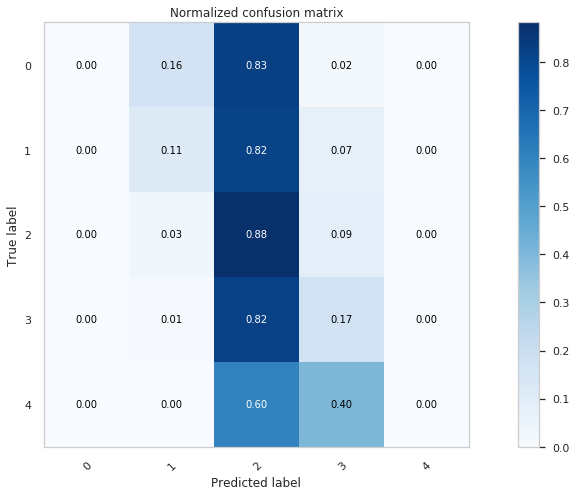

In [68]:
clf = RidgeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)

Balanced accuracy: 0.22
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.05      0.02      0.99      0.02      0.13      0.01        63
      low needs       0.29      0.31      0.77      0.30      0.49      0.23       594
 moderate needs       0.49      0.61      0.39      0.54      0.49      0.25      1258
     high needs       0.32      0.17      0.88      0.22      0.38      0.14       655
very high needs       0.00      0.00      1.00      0.00      0.00      0.00        25

    avg / total       0.38      0.41      0.62      0.39      0.45      0.21      2595

Normalized confusion matrix


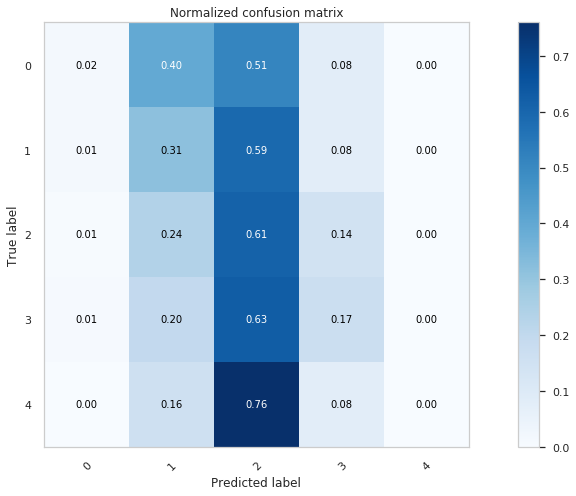

In [69]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)

Balanced accuracy: 0.34
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.09      0.49      0.87      0.15      0.65      0.41        63
      low needs       0.29      0.32      0.77      0.30      0.49      0.23       594
 moderate needs       0.64      0.01      1.00      0.01      0.07      0.00      1258
     high needs       0.35      0.01      0.99      0.02      0.11      0.01       655
very high needs       0.01      0.88      0.40      0.03      0.59      0.37        25

    avg / total       0.47      0.10      0.94      0.08      0.20      0.07      2595

Normalized confusion matrix


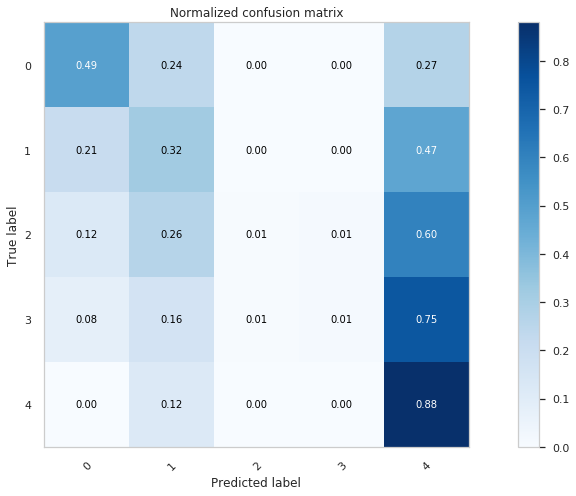

In [70]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)

Balanced accuracy: 0.27
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.23      0.16      0.99      0.19      0.40      0.14        63
      low needs       0.31      0.29      0.81      0.30      0.48      0.22       594
 moderate needs       0.50      0.58      0.46      0.54      0.52      0.27      1258
     high needs       0.37      0.31      0.83      0.34      0.50      0.24       655
very high needs       0.00      0.00      1.00      0.00      0.00      0.00        25

    avg / total       0.41      0.43      0.65      0.42      0.50      0.25      2595

Normalized confusion matrix


/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


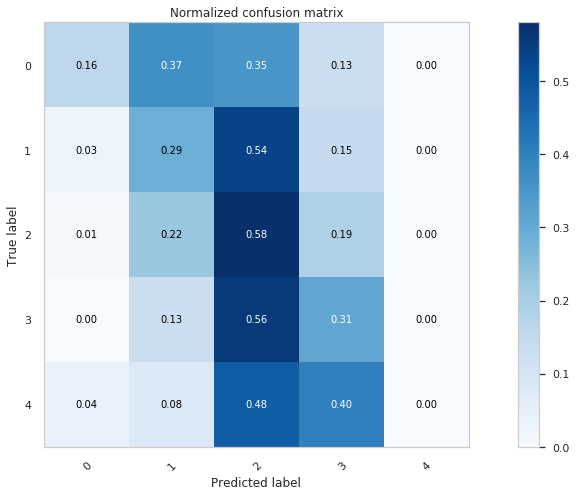

In [71]:
clf = ExtraTreesClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)

Balanced accuracy: 0.25
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.20      0.02      1.00      0.03      0.13      0.01        63
      low needs       0.52      0.18      0.95      0.27      0.42      0.16       594
 moderate needs       0.51      0.84      0.24      0.64      0.45      0.21      1258
     high needs       0.47      0.22      0.92      0.30      0.45      0.19       655
very high needs       0.00      0.00      1.00      0.00      0.00      0.00        25

    avg / total       0.49      0.51      0.60      0.45      0.43      0.19      2595

Normalized confusion matrix


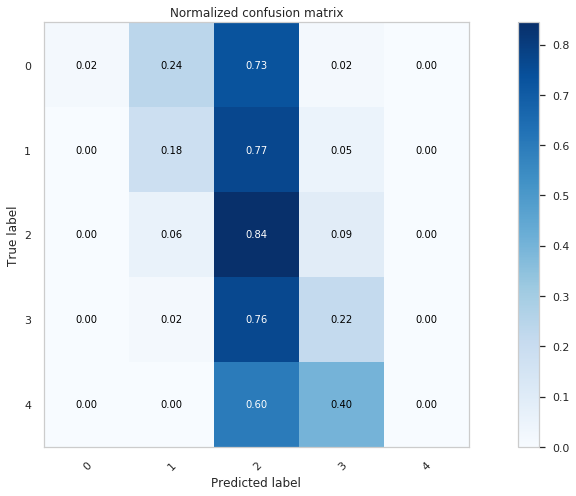

In [72]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)

## Voting Classifier

### Hard Voting

In [73]:
clf1 = KNeighborsClassifier(weights='distance')
clf2 = GaussianNB()
clf3 = ExtraTreesClassifier(class_weight='balanced_subsample')
clf4 = GradientBoostingClassifier()
vote = VotingClassifier(estimators=[('knn', clf1), ('gnb', clf2), ('ext', clf3), ('gb', clf4)], voting='hard')

In [79]:
params = {'knn__n_neighbors': [2,3,4], 'gb__n_estimators':[50,100,200],
          'gb__max_depth':[3,5,7], 'ext__n_estimators': [50,100,200]}
scoring_fns = ['f1_weighted', 'balanced_accuracy']

In [80]:
grid = GridSearchCV(estimator=vote, param_grid=params, cv=cv_, 
                    verbose=2, n_jobs=-1, scoring=scoring_fns, refit='balanced_accuracy')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.3min
/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 32.1min
/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jo

Balanced accuracy: 0.28
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.13      0.16      0.97      0.14      0.39      0.14        63
      low needs       0.31      0.34      0.77      0.32      0.51      0.25       594
 moderate needs       0.51      0.60      0.46      0.55      0.52      0.28      1258
     high needs       0.42      0.24      0.89      0.31      0.46      0.20       655
very high needs       0.07      0.04      0.99      0.05      0.20      0.04        25

    avg / total       0.43      0.43      0.66      0.42      0.50      0.25      2595

Normalized confusion matrix


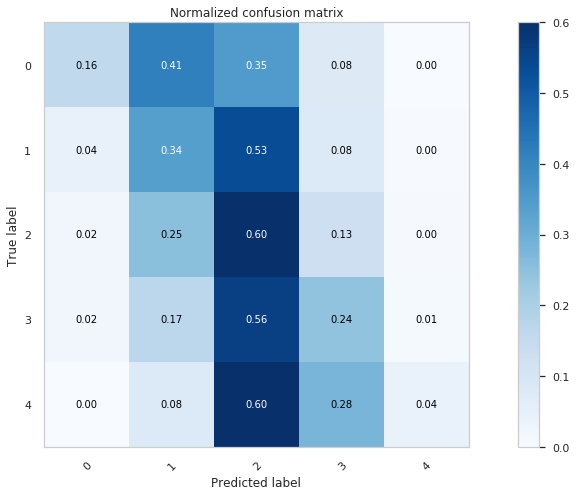

In [81]:
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)

In [84]:
clf1 = KNeighborsClassifier(weights='distance')
clf2 = GaussianNB()
clf3 = ExtraTreesClassifier(class_weight='balanced_subsample')
clf4 = GradientBoostingClassifier()
vote = VotingClassifier(estimators=[('knn', clf1), ('gnb', clf2), ('ext', clf3), ('gb', clf4)], voting='soft')

In [85]:
params = {'knn__n_neighbors': [2,3,4], 'gb__n_estimators':[50,100,200],
          'gb__max_depth':[3,5,7], 'ext__n_estimators': [50,100,200]}
scoring_fns = ['f1_weighted', 'balanced_accuracy']

In [86]:
grid_soft = GridSearchCV(estimator=vote, param_grid=params, cv=cv_, 
                    verbose=2, n_jobs=-1, scoring=scoring_fns, refit='balanced_accuracy')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 36.8min finished


Balanced accuracy: 0.29
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.19      0.10      0.99      0.13      0.31      0.09        63
      low needs       0.36      0.36      0.82      0.36      0.54      0.28       594
 moderate needs       0.52      0.62      0.46      0.57      0.53      0.29      1258
     high needs       0.43      0.28      0.87      0.34      0.50      0.23       655
very high needs       0.05      0.08      0.98      0.06      0.28      0.07        25

    avg / total       0.45      0.46      0.66      0.45      0.52      0.26      2595

Normalized confusion matrix


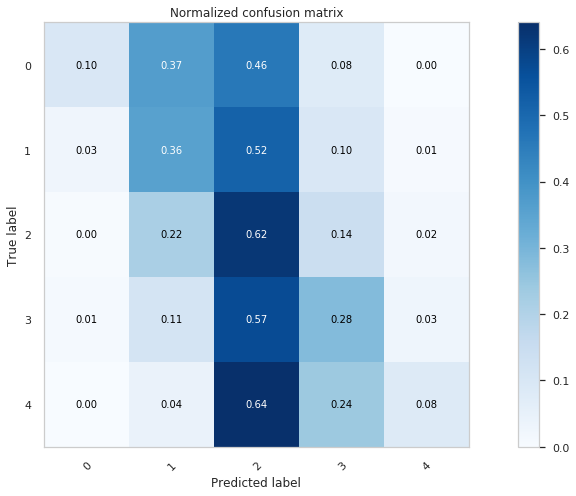

In [87]:
grid_soft.fit(X_train, y_train)
y_pred = grid_soft.predict(X_test)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)